In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import rioxarray as rioxr
import geopandas as gpd

import warnings

import planetary_computer as pc

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da
from dask_ml.wrappers import ParallelPostFit  # wrapper so that model predicts using dask

# custom modules
import data_sampling_workflow.lidar_sampling_functions as lsf
import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

In [2]:
t_alpha = time.time()

## Import & prepare train/test sets

In [3]:
# select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'avg_lidar']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

In [4]:
# remove 2012 and 2014 since these do not have LIDAR data of their own.
X_train = X_train.loc[X_train.year != 2012]
X_train = X_train.loc[X_train.year != 2014]

y_train = y_train.iloc[X_train.index]

In [5]:
# -- CHECKPOINT -- (uncomment if needed)

# verify that train set only has data for 2016, 2018 and 2020
print(X_train.year.unique())

# verify that X_train and y_train have data for same points
print(X_train.index)
print(y_train.index)

[2016 2018 2020]
Int64Index([ 24005,  24006,  24007,  24008,  24009,  24010,  24011,  24012,
             24013,  24014,
            ...
            395612, 395613, 395614, 395615, 395616, 395617, 395618, 395619,
            395620, 395621],
           dtype='int64', length=263511)
Int64Index([ 24005,  24006,  24007,  24008,  24009,  24010,  24011,  24012,
             24013,  24014,
            ...
            395612, 395613, 395614, 395615, 395616, 395617, 395618, 395619,
            395620, 395621],
           dtype='int64', length=263511)


In [6]:
mpe.iceplant_proportions(np.array(y_train))

no-iceplant:iceplant ratio     2.6 :1
          counts  percentage
iceplant                    
0         190655       72.35
1          72856       27.65



## Train model

In [7]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0), 'seconds')

time to train:  25.557655572891235 seconds


In [8]:
del X_train, y_train
gc.collect()

24

# Select NAIP scene and LIDAR year

In [9]:
# gaviota_itemids = ['ca_m_3412039_nw_10_060_20200522',
# 'ca_m_3412039_nw_10_060_20180724_20190209',
# 'ca_m_3412039_nw_10_.6_20160616_20161004',
# 'ca_m_3412039_nw_10_1_20140603_20141030',
# 'ca_m_3412039_nw_10_1_20120518_20120730']

In [10]:
campus_itemids = ['ca_m_3411934_sw_11_060_20200521',
                  'ca_m_3411934_sw_11_060_20180722_20190209',
                  'ca_m_3411934_sw_11_.6_20160713_20161004']

In [11]:
# **************************************************************
# ********* SPECIFY ITEMID AND LIDAR YEAR TO MATCH HERE ********

itemid = campus_itemids[2] # NAIP scene over Conception Point
lidar_year = 2016
save_raster = True
filename = 'LIDAR+NAIP_campus_'+str(lidar_year)+'_predictions.tif'

# **************************************************************
# **************************************************************

# Open NAIP scene for classification

In [20]:
naip_item =ipf.get_item_from_id(itemid)
href = pc.sign(naip_item.assets["image"].href)
 
# rioxarray of complete naip scene
naip_scene = rioxr.open_rasterio(rasterio.open(href))

# Prepare LIDAR data for sampling

In [13]:
t0 = time.time()
# Create auxiliary LIDAR files to sample from

fp = lsf.path_to_lidar(lidar_year)
lidar_reader = rasterio.open(fp)
lsf.save_min_max_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)
lsf.save_avg_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)

print('time to make auxiliary rasters: ', (time.time()-t0), 'seconds')

time to make auxiliary rasters:  6.829832077026367 seconds


In [14]:
# Resample lidar layers to match NAIP scene resolution and extent

lidar_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_mins_'+str(lidar_year)+'.tif')
mins_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_maxs_'+str(lidar_year)+'.tif')
maxs_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_avgs_'+str(lidar_year)+'.tif')
avg_match = lsf.open_and_match(fp, naip_scene)

In [16]:
# Assemble LIDAR layers into dataframe 
t0 = time.time()

df_lidar = pd.DataFrame()
df_lidar['lidar'] = lidar_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['max_lidar'] = maxs_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_lidar'] = mins_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_max_diff'] = df_lidar.max_lidar - df_lidar.min_lidar
df_lidar['avg_lidar'] = avg_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])

print('time to assemble dataframe: ', (time.time()-t0), 'seconds')

time to assemble dataframe:  8.482627630233765 seconds


In [17]:
# clear memory
del avg_match, mins_match, maxs_match, lidar_match
gc.collect()

0

In [18]:
# Delete auxiliary LIDAR rasters in temp folder
lidar_fps = []
for tag in ['maxs_', 'mins_', 'avgs_']:
    lidar_fps.append(os.path.join(os.getcwd(),
                                  'temp',
                                  'lidar_'+tag+ str(lidar_year)+'.tif'))
for fp in lidar_fps:
    os.remove(fp)

In [19]:
# lidar_reader.height
# lidar_reader.width

11436

# Select points to be classified using NDVI threshold

In [21]:
# select pixels above ndvi threshold
veg = ipf.features_over_aoi(naip_item, 
                           naip_scene.to_numpy(), 
                           thresh=0.05)

print('time to select above ndvi thresh: ', (time.time()-t0), 'seconds')
veg

,r,g,b,nir,ndvi,year,month,day_in_year
1,50,50,66,57,0.065421,2016,7,195
2,46,47,58,52,0.061224,2016,7,195
4,44,46,58,52,0.083333,2016,7,195
5,46,47,58,56,0.098039,2016,7,195
6,81,81,77,114,0.169231,2016,7,195
...,...,...,...,...,...,...,...,...
128567088,29,40,56,36,0.107692,2016,7,195
128567543,34,47,64,39,0.068493,2016,7,195
128573373,46,70,67,51,0.051546,2016,7,195
128576369,53,71,77,61,0.070175,2016,7,195


# Sample and add LIDAR to vegetation pixels

In [22]:
# select same indices as vegetation
t0 = time.time()

df_lidar_veg = df_lidar.iloc[veg.index]

print('time to select lidar corresponding to veg: ', (time.time()-t0), 'seconds')
df_lidar_veg

time to select lidar corresponding to veg:  1.1330909729003906 seconds


,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
1,3,3,2,1,2.444444e+00
2,3,3,2,1,2.444444e+00
4,3,3,2,1,2.444444e+00
5,3,3,2,1,2.444444e+00
6,3,3,2,1,2.444444e+00
...,...,...,...,...,...
128567088,-32768,255,255,0,3.402823e+38
128567543,-32768,255,255,0,3.402823e+38
128573373,-32768,255,255,0,3.402823e+38
128576369,-32768,255,255,0,3.402823e+38


In [23]:
# add LIDAR features to vegetation dataframe

# FEATURES MUST BE IN THIS ORDER TO MATCH THE MODEL:
# ['r', 'g', 'b', 'nir', 'ndvi', 
#  'year', 'month', 'day_in_year',
#  'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])

scene_features = pd.concat([veg,df_lidar_veg],axis=1)
scene_features.head(2)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
1,50,50,66,57,0.065421,2016,7,195,3,3,2,1,2.444444
2,46,47,58,52,0.061224,2016,7,195,3,3,2,1,2.444444


In [24]:
# clear memory
del veg, df_lidar, df_lidar_veg
gc.collect()

47

# Make dask data array of pixel values from NAIP scene raster

In [25]:
da_pixels = da.from_array(scene_features.to_numpy(), chunks=728802)
da_pixels

dask.array<array, shape=(29293669, 13), dtype=float64, chunksize=(728802, 13), chunktype=numpy.ndarray>

# Initialize Dask Cluster

In [26]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.06e36af2b30141269aaebba26c13185f/status,


# Predict using dask

In [27]:
# initialize
predictions = rfc.predict(da_pixels)
predictions

time to predict with dask:  0.04931998252868652 seconds


/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [28]:
# compute predictions
t0 = time.time()

preds = predictions.compute()
print('time to predict: ', time.time()-t0)

time to predict:  115.34789443016052


# Reassemble predictions into image

In [ ]:
t0 = time.time()
preds_image = ipf.preds_to_image_3labels(naip_scene.shape[1], naip_scene.shape[2], 
                                     scene_features.index,
                                     preds)
print('indices to image time: ', time.time()-t0)

indices to image time:  1.7799181938171387


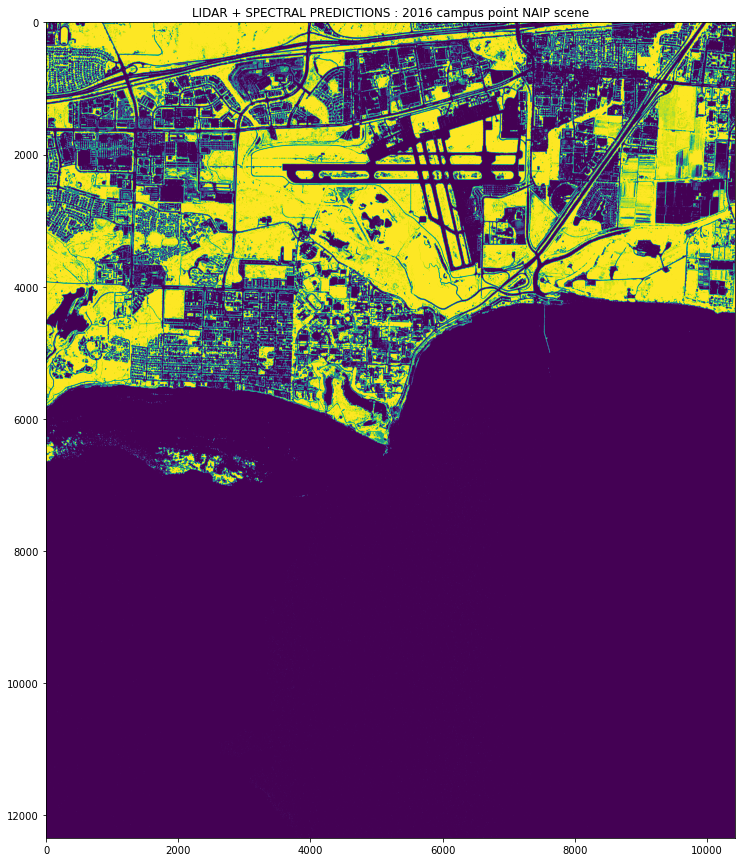

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("LIDAR + SPECTRAL PREDICTIONS : "+str(lidar_year)+ " campus point NAIP scene")
ax.imshow(preds_image)
plt.show()

In [31]:
# save if necessary

if save_raster == True:
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = preds_image.shape[0], 
        width = preds_image.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = naip_scene.rio.crs,
        transform = naip_scene.rio.transform(),
    ) as dst:
        dst.write(preds_image.astype(rasterio.uint8), 1)

In [32]:
# clean memory
del naip_scene, scene_features
del preds_image, predictions
gc.collect()

215

In [33]:
print('total time:', time.time() - t_alpha )

total time: 666.0582957267761
